In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
print("GPUs detected:", gpus)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())

TF Version: 2.19.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
Built with GPU support: True


In [2]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00


In [3]:
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"

import random
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# TensorFlow and Keras
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Image augmentation
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

# Segmentation Models
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
print(sm.framework())  # should output: "tf.keras"

tf.keras


In [5]:
DATA_DIR = "drive/MyDrive/restaurAr-T/data/v6-split-dataset/"

In [6]:
x_train_dir = os.path.join(DATA_DIR, "train/img/")
y_train_dir = os.path.join(DATA_DIR, "train/mask/")

x_valid_dir = os.path.join(DATA_DIR, "val/img/")
y_valid_dir = os.path.join(DATA_DIR, "val/mask/")

x_test_dir = os.path.join(DATA_DIR, "test/img/")
y_test_dir = os.path.join(DATA_DIR, "test/mask/")

In [7]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row with expanded, user-friendly titles."""
    # Mapping from keys to expanded titles
    title_map = {
        "image": "Input Image",
        "ground_truth_mask": "Ground Truth Mask",
        "gt_mask": "Ground Truth Mask",
        "predicted_mask": "Predicted Mask",
        "pr_mask": "Predicted Mask",
        "mask": "Mask"
    }

    n = len(images)
    plt.figure(figsize=(5 * n, 5))  # scalable size per image

    for i, (name, image) in enumerate(images.items()):
        title = title_map.get(name, " ".join(name.split("_")).title())
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(title)
        plt.imshow(image, cmap="gray" if image.ndim == 2 else None)

    plt.tight_layout()
    plt.show()


# helper function for data visualization
def denormalize(x):
    """Safely scale image to 0–1 for visualization."""
    x = np.array(x)  # just in case it's a tensor
    x_max = np.nanpercentile(x, 98)
    x_min = np.nanpercentile(x, 2)
    denom = x_max - x_min

    # avoid division by zero
    if denom == 0 or np.isnan(denom):
        return np.zeros_like(x)

    x = (x - x_min) / denom
    x = np.clip(x, 0, 1)
    return x


def load_npz_with_aug(path_and_aug):
    path, augment_fn = path_and_aug
    with np.load(path) as data:
        image = data['image']
        mask = data['mask']

        # CLAHE (applied on L channel of LAB)
        image_uint8 = (image * 255).astype(np.uint8)
        lab = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        cl = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(l)
        lab_clahe = cv2.merge((cl, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB).astype(np.float32) / 255.0

        # Albumentations augmentations
        if augment_fn:
            augmented = augment_fn(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask


def batch_generator(file_paths, batch_size, augment_fn=None, shuffle=True, max_workers=4):
    while True:
        if shuffle:
            random.shuffle(file_paths)

        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            args = [(p, augment_fn) for p in batch_paths]

            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                results = list(executor.map(load_npz_with_aug, args))

            images, masks = zip(*results)
            yield np.stack(images), np.stack(masks)


In [8]:
# classes for data loading and preprocessing
class Dataset:
    """Damage Detection Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline
        preprocessing (albumentations.Compose): data preprocessing pipeline
    """

    def __init__(
        self,
        images_dir,
        masks_dir,
        classes=None,
        augmentation=None,
        preprocessing=None,
        subset_size=None  # NEW
    ):
        self.all_ids = os.listdir(masks_dir)
        self.base_ids = [mask_id.replace('-mask.png', '') for mask_id in self.all_ids]

        # Apply subset sampling
        if subset_size:
            n = int(len(self.base_ids) * subset_size) if isinstance(subset_size, float) else subset_size
            self.base_ids = self.base_ids[:n]
            self.all_ids = self.all_ids[:n]

        self.ids = self.all_ids

        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.all_ids]
        self.images_fps = [os.path.join(images_dir, base_id + '.png') for base_id in self.base_ids]

        for path in self.images_fps:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Image not found: {path}")

        self.class_values = [1]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Failed to read image at: {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_path = self.masks_fps[i]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Failed to read mask at: {mask_path}")

        mask = np.where(mask > 0, 1, 0).astype('float32')
        mask = np.expand_dims(mask, axis=-1)

        # Apply augmentation
        if self.augmentation is not None:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        image = image.astype("float32")
        return image, mask

    def __len__(self):
        return len(self.ids)

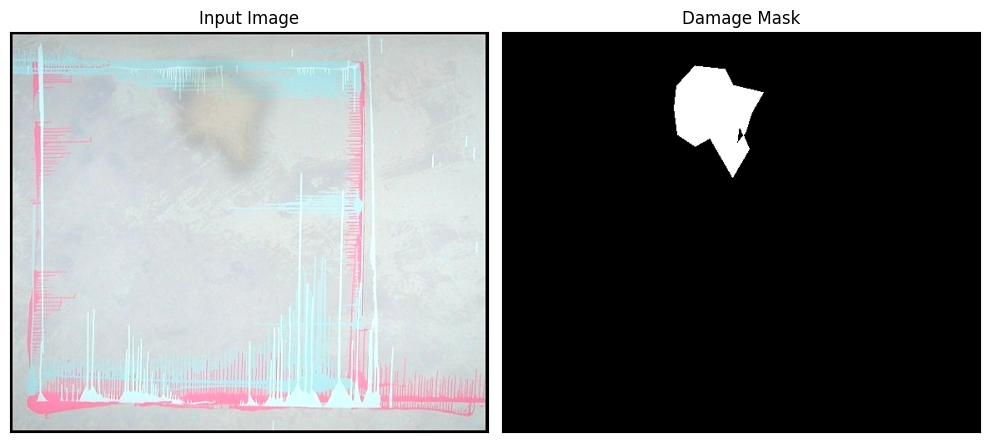

In [9]:
# Quick check on the dataset
dataset = Dataset(x_train_dir, y_train_dir, classes=["damage"])

image, mask = dataset[5]  # get some sample
visualize(
    image=denormalize(image),
    damage_mask=mask[..., 0].squeeze()
)

In [10]:
# Clip and round mask values to [0, 1]
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)


# Convert float32 image (0..1) to uint8 (0..255)
def to_uint8(x, **kwargs):
    return (x * 255).astype(np.uint8)


# Convert uint8 image (0..255) back to float32 (0..1)
def to_float32(x, **kwargs):
    return x.astype(np.float32) / 255.0


# CLAHE that works with float32 inputs by wrapping uint8 conversion
def safe_clahe():
    return A.Compose([
        A.Lambda(image=to_uint8),
        A.CLAHE(p=1),
        A.Lambda(image=to_float32),
    ])


# Heavy augmentation pipeline
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(
            shift_limit=0.05,     # safer shift
            scale_limit=0.2,      # moderate zoom
            rotate_limit=10,      # slight rotation
            p=1,
            border_mode=cv2.BORDER_REFLECT_101  # avoids black padding
        ),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=cv2.BORDER_REFLECT_101),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.5),

        A.OneOf([
            safe_clahe(),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=1),
            A.RandomGamma(p=1),
        ], p=0.9),

        A.OneOf([
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1),
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ], p=0.9),

        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, p=1),
            A.HueSaturationValue(p=1),
        ], p=0.9),

        A.Lambda(mask=round_clip_0_1)
    ]

    return A.Compose(train_transform)


def get_training_light_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Resize(320, 320),
        A.Lambda(mask=round_clip_0_1)
    ])


# Simple resize for validation
def get_validation_augmentation():
    return A.Compose([
        A.Resize(320, 320)
    ])

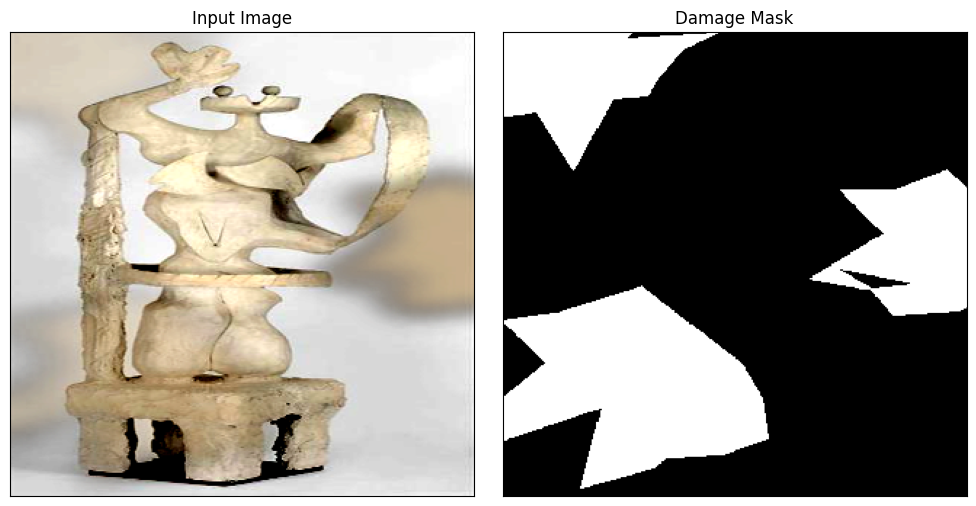

In [11]:
# Quick check on the augmented data
dataset = Dataset(x_train_dir, y_train_dir, classes=["damage"], augmentation=get_training_light_augmentation())

image, mask = dataset[12]  # get some sample
visualize(
    image=denormalize(image),
    damage_mask=mask[..., 0].squeeze(),
)


In [12]:
# Model and training configuration
BACKBONE = "resnet34"
INPUT_SHAPE = (320, 320, 3)
ENCODER_WEIGHTS = "imagenet"
BATCH_SIZE = 32
CLASSES = ["damage"]
LR = 0.0001
EPOCHS = 100

# Define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # add background if multiclass
activation = "sigmoid" if n_classes == 1 else "softmax"     # use sigmoid for binary, softmax for multiclass

In [13]:
# Create U-Net model with chosen backbone and parameters
model = sm.Unet(
    backbone_name=BACKBONE,
    encoder_weights=ENCODER_WEIGHTS,
    encoder_freeze=True,
    input_shape=INPUT_SHAPE,
    classes=n_classes,
    activation=activation
)

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(LR)

# Define loss components
dice_loss = sm.losses.DiceLoss()
if n_classes == 1:
    focal_loss = sm.losses.BinaryFocalLoss()
    total_loss = dice_loss + focal_loss  # or sm.losses.binary_focal_dice_loss
else:
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + focal_loss  # or sm.losses.categorical_focal_dice_loss

# Define metrics
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.Precision(),
    sm.metrics.Recall(),
    sm.metrics.FScore(threshold=0.5),
]

# Compile model
model.compile(
    optimizer=optimizer,
    loss=total_loss,
    metrics=metrics
)

In [15]:
# Define callbacks: model checkpointing and learning rate reduction
callbacks = [
    # Save best by val_loss
    keras.callbacks.ModelCheckpoint(
        filepath="drive/MyDrive/restaurAr-T/models/v6-best-val_loss.weights.h5",
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True,
        mode="min"
    ),

    # Save best by IoU
    keras.callbacks.ModelCheckpoint(
        filepath="drive/MyDrive/restaurAr-T/models/v6-best-val_iou.weights.h5",
        monitor="val_iou_score",
        save_weights_only=True,
        save_best_only=True,
        mode="max"
    ),

    # Save best by F1-score
    keras.callbacks.ModelCheckpoint(
        filepath="drive/MyDrive/restaurAr-T/models/v6-best-f1.weights.h5",
        monitor="val_f1-score",
        save_weights_only=True,
        save_best_only=True,
        mode="max"
    ),

    # Save best by Precision
    keras.callbacks.ModelCheckpoint(
        filepath="drive/MyDrive/restaurAr-T/models/v6-best-precision.weights.h5",
        monitor="val_precision",
        save_weights_only=True,
        save_best_only=True,
        mode="max"
    ),

    # Save best by Recall
    keras.callbacks.ModelCheckpoint(
        filepath="drive/MyDrive/restaurAr-T/models/v6-best-recall.weights.h5",
        monitor="val_recall",
        save_weights_only=True,
        save_best_only=True,
        mode="max"
    ),

    # Reduce LR on plateau of val_loss
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1
    ),

    # Stop early if val_loss doesn't improve
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

In [22]:
train_file_paths = sorted(glob.glob("drive/MyDrive/restaurAr-T/data/v6-preprocessed-npz/train/*.npz"))
val_file_paths   = sorted(glob.glob("drive/MyDrive/restaurAr-T/data/v6-preprocessed-npz/valid/*.npz"))

train_gen = batch_generator(train_file_paths, batch_size=BATCH_SIZE, augment_fn=get_training_light_augmentation())
val_gen = batch_generator(val_file_paths, batch_size=BATCH_SIZE, augment_fn=get_validation_augmentation(), shuffle=False)

In [23]:
steps_per_epoch = math.ceil(len(train_file_paths) / BATCH_SIZE)
validation_steps = math.ceil(len(val_file_paths) / BATCH_SIZE)

In [25]:
# Copiar el dataset preprocesado de Google Drive al disco local de Colab
# Esto es esencial para eliminar el cuello de botella de E/S.
local_data_dir = '/content/v6-preprocessed-npz'
!cp -r drive/MyDrive/restaurAr-T/data/v6-preprocessed-npz {local_data_dir}
print("¡Datos copiados localmente! La ruta a usar ahora es /content/v6-preprocessed-npz")

^C
¡Datos copiados localmente! La ruta a usar ahora es /content/v6-preprocessed-npz


In [26]:
import math

# 1. Usar la nueva ruta local
local_data_dir = "/content/v6-preprocessed-npz" # Usamos la ruta local

train_file_paths = sorted(glob.glob(f"{local_data_dir}/train/*.npz"))
val_file_paths   = sorted(glob.glob(f"{local_data_dir}/valid/*.npz"))

# 2. Aumentar max_workers para el procesamiento paralelo del CPU
# (Generalmente 8 es un buen valor para Colab)
MAX_WORKERS = 8

train_gen = batch_generator(
    train_file_paths,
    batch_size=BATCH_SIZE,
    augment_fn=get_training_light_augmentation(),
    max_workers=MAX_WORKERS # <--- APLICADO AQUÍ
)

val_gen = batch_generator(
    val_file_paths,
    batch_size=BATCH_SIZE,
    augment_fn=get_validation_augmentation(),
    shuffle=False,
    max_workers=MAX_WORKERS # <--- APLICADO AQUÍ
)

# 3. Recalcular steps_per_epoch y validation_steps
steps_per_epoch = math.ceil(len(train_file_paths) / BATCH_SIZE)
validation_steps = math.ceil(len(val_file_paths) / BATCH_SIZE)

print(f"Total training files: {len(train_file_paths)}")
print(f"Total validation files: {len(val_file_paths)}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Total training files: 33140
Total validation files: 7101
Steps per epoch: 1036
Validation steps: 222


In [27]:
# Add logger to keep track of training even if it crashes
csv_logger = CSVLogger("drive/MyDrive/restaurAr-T/outputs/v6-training_history.csv", append=True)
callbacks.append(csv_logger)

try:
    history = model.fit(
        x=train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
except Exception as e:
    print(f"[CRASH] Training interrupted: {e}")
    model.save_weights("drive/MyDrive/restaurAr-T/models/v6-interrupted.h5")

Epoch 1/100
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 443s 427ms/step - f1-score: 0.4363 - iou_score: 0.2845 - loss: 0.7345 - precision: 0.2636 - recall: 0.5072 - val_f1-score: 0.5715 - val_iou_score: 0.4008 - val_loss: 0.5950 - val_precision: 0.4487 - val_recall: 0.5523 - learning_rate: 1.0000e-04
Epoch 2/100
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 384s 371ms/step - f1-score: 0.6096 - iou_score: 0.4392 - loss: 0.5195 - precision: 0.5432 - recall: 0.5517 - val_f1-score: 0.7088 - val_iou_score: 0.5499 - val_loss: 0.4253 - val_precision: 0.6514 - val_recall: 0.6856 - learning_rate: 1.0000e-04
Epoch 3/100
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 350s 338ms/step - f1-score: 0.6508 - iou_score: 0.4831 - loss: 0.4634 - precision: 0.6262 - recall: 0.5854 - val_f1-score: 0.7223 - val_iou_score: 0.5663 - val_loss: 0.4277 - val_precision: 0.6256 - val_recall: 0.7715 - learning_rate: 1.0000e-04
Epoch 4/100
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 317s 306ms/step - f1-score: 0.6743 - iou_score: 0.5094 - loss: 0.4331 - precision: 0.6650 

In [28]:
def plot_training_history(history, metrics=("iou_score",), save_path=None):
    """
    Plots training and validation metrics and loss curves.

    Parameters:
        history (keras.callbacks.History): Training history object returned by model.fit().
        metrics (tuple of str): Metric names to plot. Defaults to ("iou_score",).
        save_path (str or None):ala If specified, saves the plot to this path.
    """
    num_metrics = len(metrics)
    plt.figure(figsize=(7 * num_metrics, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, i + 1)
        plt.plot(history.history[metric], label="Train")
        plt.plot(history.history["val_" + metric], label="Validation")
        plt.title(f"Model {metric.replace('_', ' ').title()}")
        plt.xlabel("Epoch")
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend(loc="upper left")
        plt.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


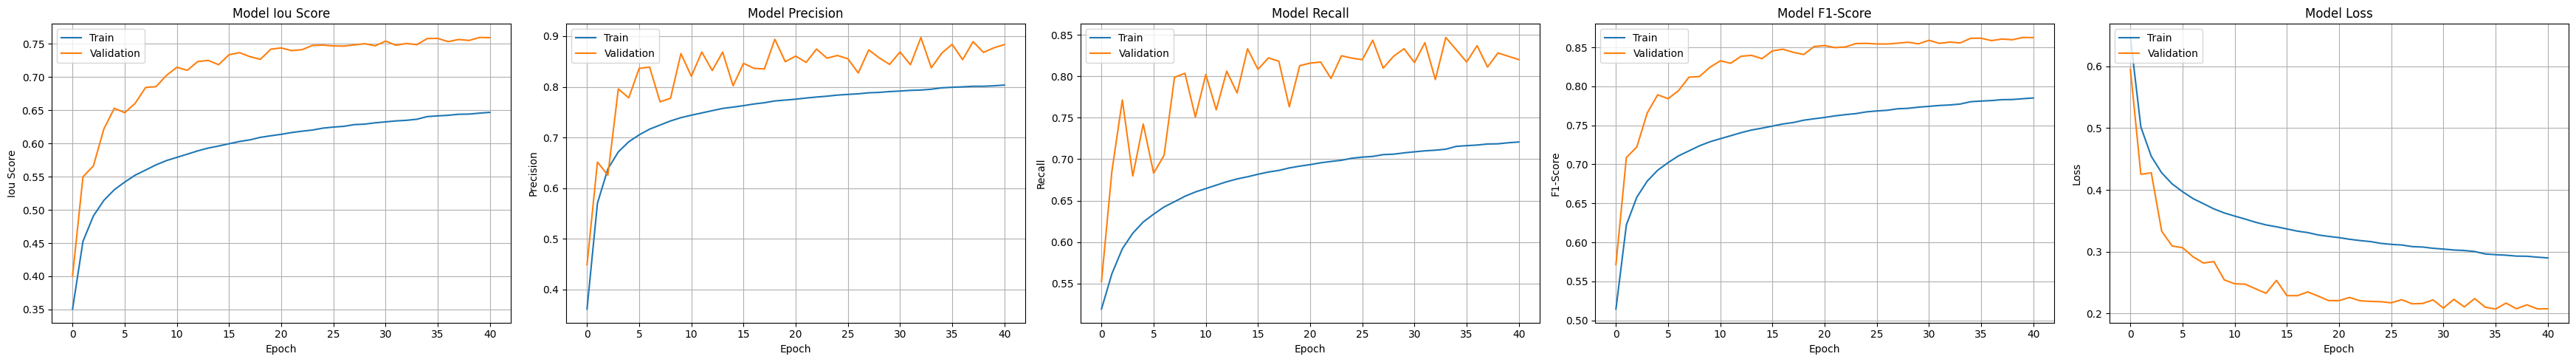

In [29]:
plot_training_history(history, metrics=("iou_score", "precision",
                                        "recall", "f1-score", "loss"))

In [30]:
# Model parameters
BACKBONE = "resnet34"
INPUT_SHAPE = (320, 320, 3)
CLASSES = ["damage"]

n_classes = 1 if len(CLASSES) == 1 else len(CLASSES) + 1
activation = "sigmoid" if n_classes == 1 else "softmax"

# Define model
best_model = sm.Unet(
    backbone_name=BACKBONE,
    encoder_weights=None,
    encoder_freeze=False,
    input_shape=INPUT_SHAPE,
    classes=n_classes,
    activation=activation
)

# Define loss and metrics
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.Precision(),
    sm.metrics.Recall(),
    sm.metrics.FScore(threshold=0.5),
]

# Compile and load weights
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=total_loss,
    metrics=metrics
)

# Best model will be based on iou metric
best_model.load_weights("drive/MyDrive/restaurAr-T/models/v6-best-val_iou.h5")

In [31]:
# Prepare test file paths and generator
test_file_paths = sorted(glob.glob("drive/MyDrive/restaurAr-T/data/v6-preprocessed-npz/test/*.npz"))
test_gen = batch_generator(test_file_paths, batch_size=BATCH_SIZE, shuffle=False)

# Determine number of steps
test_steps = len(test_file_paths)
print(f"Test size: {test_steps}")

Test size: 7102


In [32]:
# Evaluate the best model
scores = best_model.evaluate(test_gen, steps=test_steps, verbose=1)

# Display results
print("Loss: {:.5f}".format(scores[0]))
for name, value in zip(best_model.metrics_names[1:], scores[1:]):
    print("Mean {}: {:.5f}".format(name, value))

7102/7102 ━━━━━━━━━━━━━━━━━━━━ 1556s 218ms/step - f1-score: 0.8189 - iou_score: 0.6959 - loss: 0.2349 - precision: 0.7929 - recall: 0.8219
Loss: 0.23527
Mean compile_metrics: 0.69574


In [33]:
def visualize_random_predictions(model, file_paths, augment_fn=None, n=5):
    """Visualize n random predictions using raw file paths instead of a generator."""
    sampled_paths = random.sample(file_paths, n)

    for path in sampled_paths:
        # Load and preprocess image + mask
        with np.load(path) as data:
            image = data['image']
            mask = data['mask']

        # Apply augmentation if specified
        if augment_fn:
            augmented = augment_fn(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # CLAHE or other preprocessing (if applicable)
        image_uint8 = (image * 255).astype(np.uint8)
        lab = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        cl = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(l)
        lab_clahe = cv2.merge((cl, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB).astype(np.float32) / 255.0

        # Predict mask
        prob_mask = model.predict(np.expand_dims(image, axis=0))[0]
        binary_mask = (prob_mask > 0.5).astype(np.float32)

        # Visualize
        visualize(
            image=denormalize(image),
            ground_truth_mask=mask[..., 0].squeeze(),
            predicted_mask=binary_mask[..., 0].squeeze()
        )

In [34]:
visualize_random_predictions(
    model=best_model,
    file_paths=test_file_paths,
    augment_fn=None,  # No augmentation during testing/visualization
    n=5
)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
def predict_mask(model, image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (320, 320))
    img = img.astype(np.float32) / 255.0

    # Add batch dimension
    input_tensor = np.expand_dims(img, axis=0)  # shape (1, 320, 320, 3)

    # Predict
    pred_mask = model.predict(input_tensor)[0]  # shape (320, 320, 1)

    # Threshold to binary
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    return denormalize(img), pred_mask[..., 0], binary_mask[..., 0]

In [36]:
def visualize_prediction(model, image_path):
    original_img, prob_mask, binary_mask = predict_mask(model, image_path)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask (probability)")
    plt.imshow(prob_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Binary Mask")
    plt.imshow(binary_mask, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


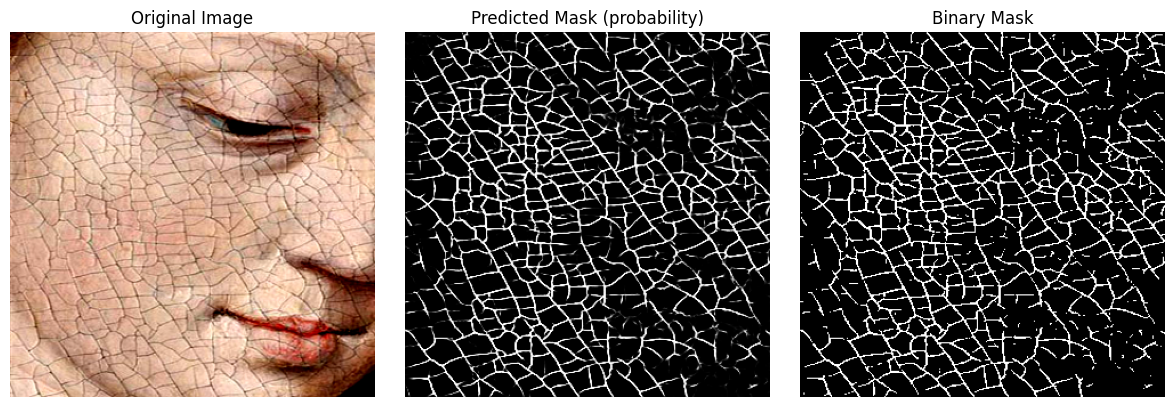

In [37]:
visualize_prediction(best_model, "drive/MyDrive/restaurAr-T/data/cracked-portrait.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


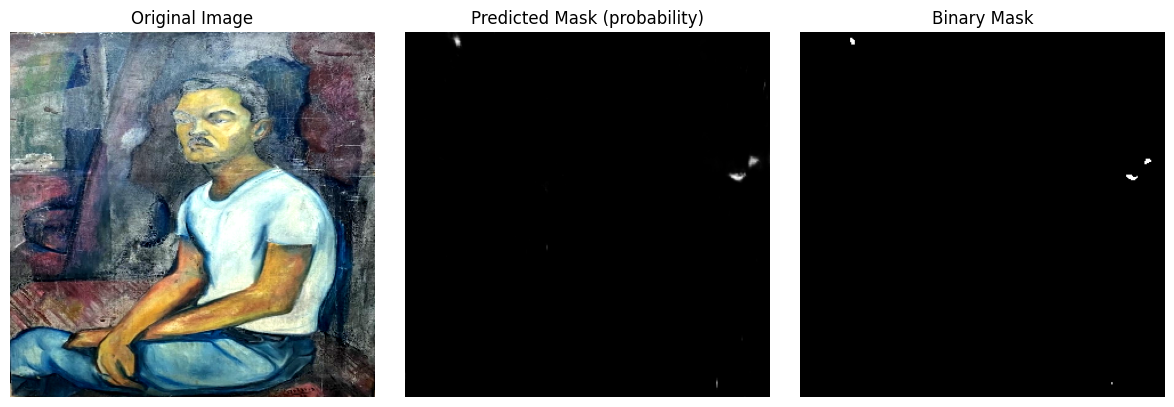

In [38]:
visualize_prediction(best_model, "drive/MyDrive/restaurAr-T/data/leon-gallery-sample.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


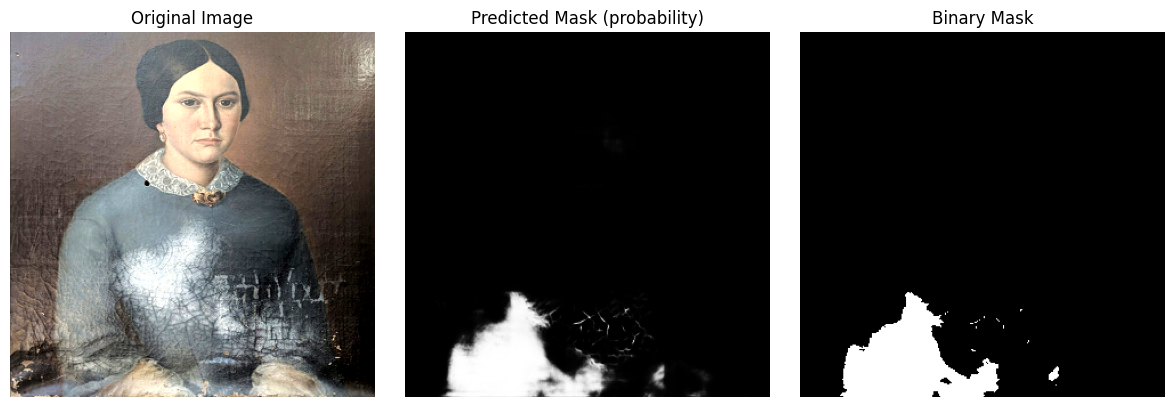

In [39]:
visualize_prediction(best_model, "drive/MyDrive/restaurAr-T/data/fine-art-restoration-waterdamaged-bluelady-before.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


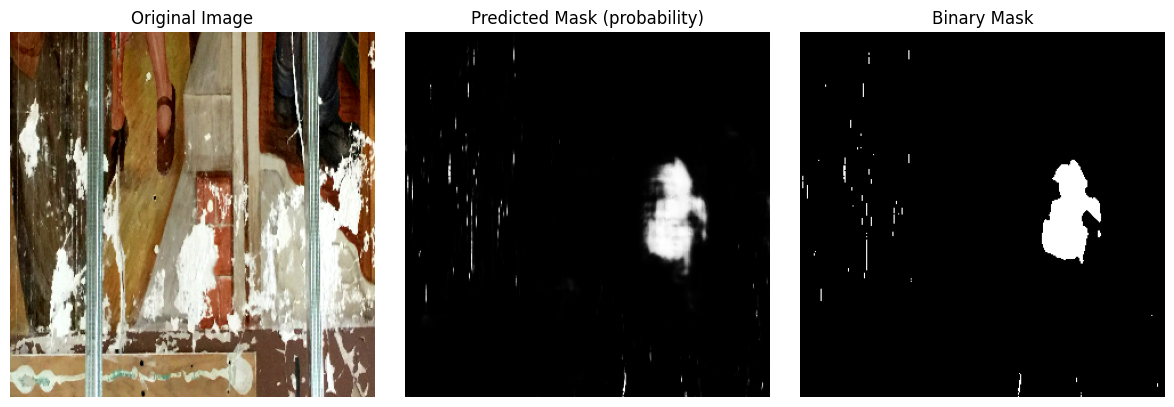

In [40]:
visualize_prediction(best_model, "drive/MyDrive/restaurAr-T/data/different-types-of-art-damage-NB-min.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


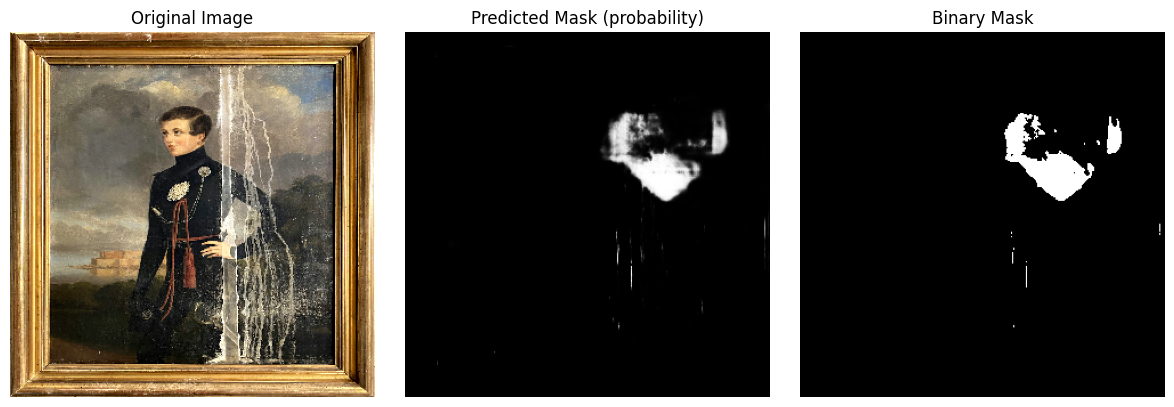

In [41]:
visualize_prediction(best_model, "drive/MyDrive/restaurAr-T/data/fine-art-restoration-leak-damaged-boy-before.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


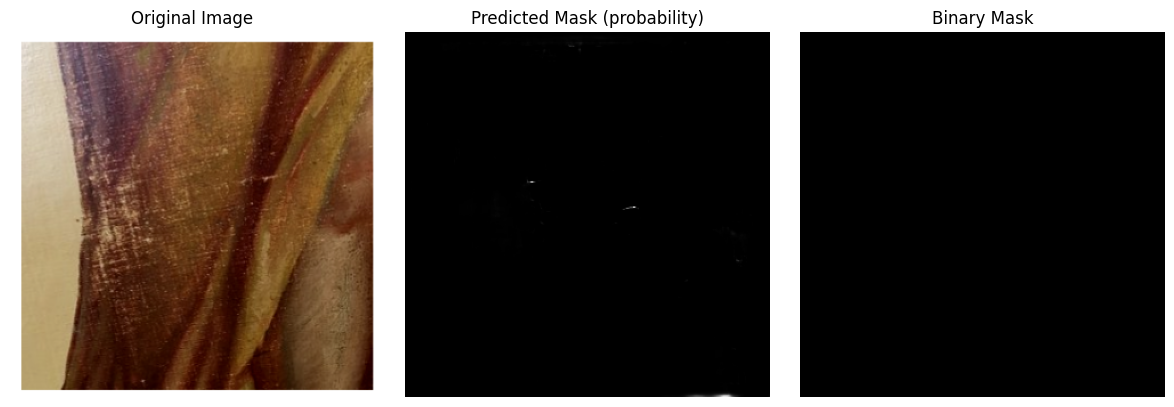

In [42]:
visualize_prediction(best_model, "drive/MyDrive/restaurAr-T/data/scratch.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


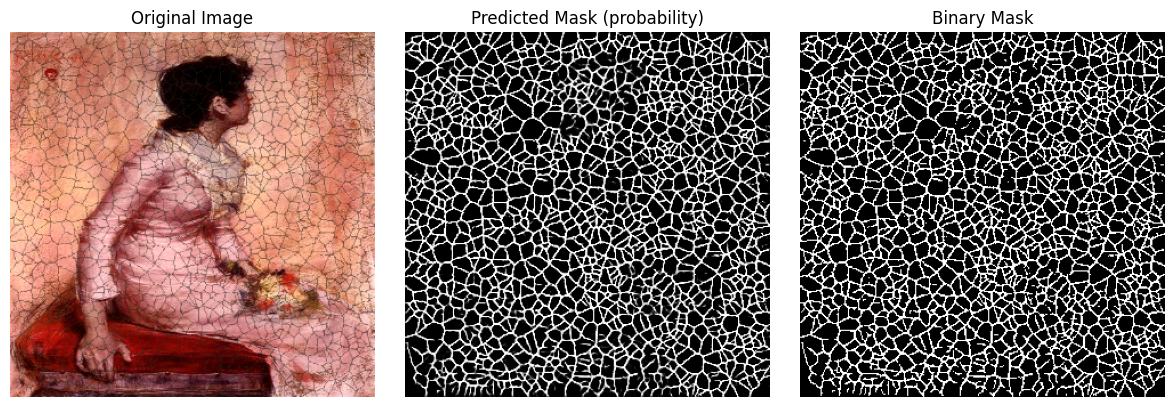

In [47]:
visualize_prediction(best_model, "drive/MyDrive/restaurAr-T/data/img03.png")

Inpainting

In [48]:
# Importar librerías de restauración de scikit-image
from skimage.restoration import inpaint
import numpy as np
# Si el código de inpainting usa data.astronaut, necesitarás skimage.data para cargar una imagen de prueba
from skimage import io
import matplotlib.pyplot as plt

In [58]:
# Asegúrate de usar las dimensiones y normalización que usaste para entrenar (Ej: 256x256)
IMG_SIZE = 320

def preprocess_image(path):
    """Carga y preprocesa una imagen para la predicción del modelo U-Net."""
    # 1. Cargar la imagen
    image = cv2.imread(path) # Usando cv2, que ya está importado en test01
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. Guardar la imagen original para el inpainting (importante)
    image_original = image.copy()

    # 3. Reescalar para la entrada del modelo
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # 4. Normalizar (depende de cómo entrenaste tu modelo, por ejemplo, / 255.0)
    image_normalized = image / 255.0

    # 5. Añadir la dimensión del batch (1, H, W, C)
    input_tensor = np.expand_dims(image_normalized, axis=0)

    # Devolvemos el tensor de entrada y la imagen original
    return input_tensor, image_original

In [59]:
# --- PARTE 1: Configuración y Carga ---
# Define la ruta de la imagen que quieres restaurar (debe ser una imagen con daño)
PATH_TO_TEST_IMAGE = 'drive/MyDrive/restaurAr-T/data/img03.png'

# Carga el tensor de entrada para el modelo y la imagen original (sin normalizar)
input_tensor, image_original_size = preprocess_image(PATH_TO_TEST_IMAGE)

In [60]:
# --- PARTE 2: Segmentación Semántica (Generación de Máscara) ---

# Asegúrate de que tu modelo ya está cargado, por ejemplo:
# model = tf.keras.models.load_model('best_model.h5', compile=False)

# 1. Predecir la máscara de daño
# La predicción devuelve probabilidades (Ej: (1, 256, 256, 1))
predicted_mask_probs = model.predict(input_tensor)[0]

# 2. Binarizar la máscara de probabilidad (convertir a 0 o 1)
# Se usa un umbral de 0.5, ajusta si es necesario
mask_binary = (predicted_mask_probs > 0.5).astype(np.uint8)

# 3. Eliminar la dimensión de canal (squeeze) para obtener (Alto, Ancho)
mask_binary_squeezed = np.squeeze(mask_binary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [63]:
# --- PARTE 3: Inpainting (Relleno) ---

# Las dimensiones de la máscara (H, W) deben coincidir con la imagen original (H, W, C).
H_orig, W_orig, _ = image_original_size.shape

# 1. Reescalar la máscara binaria a las dimensiones de la imagen original
# Esto es CRUCIAL, ya que el modelo trabaja en 256x256, pero el inpainting se aplica al tamaño original.
mask_resized = cv2.resize(mask_binary_squeezed, (W_orig, H_orig),
                          interpolation=cv2.INTER_NEAREST)

# 2. Convertir la máscara a formato booleano (True/False)
# 'True' indica las áreas a rellenar (el daño)
mask_boolean = mask_resized.astype(bool)

# 3. Aplicar la función de inpainting de scikit-image
# La función requiere una imagen, la máscara booleana y multichannel=True para RGB.
image_restored = inpaint.inpaint_biharmonic(
    image_original_size, # Imagen original (sin normalizar)
    mask_boolean,         # Máscara booleana
    channel_axis=2       # Indica que la imagen tiene canales en el último eje (RGB)
)

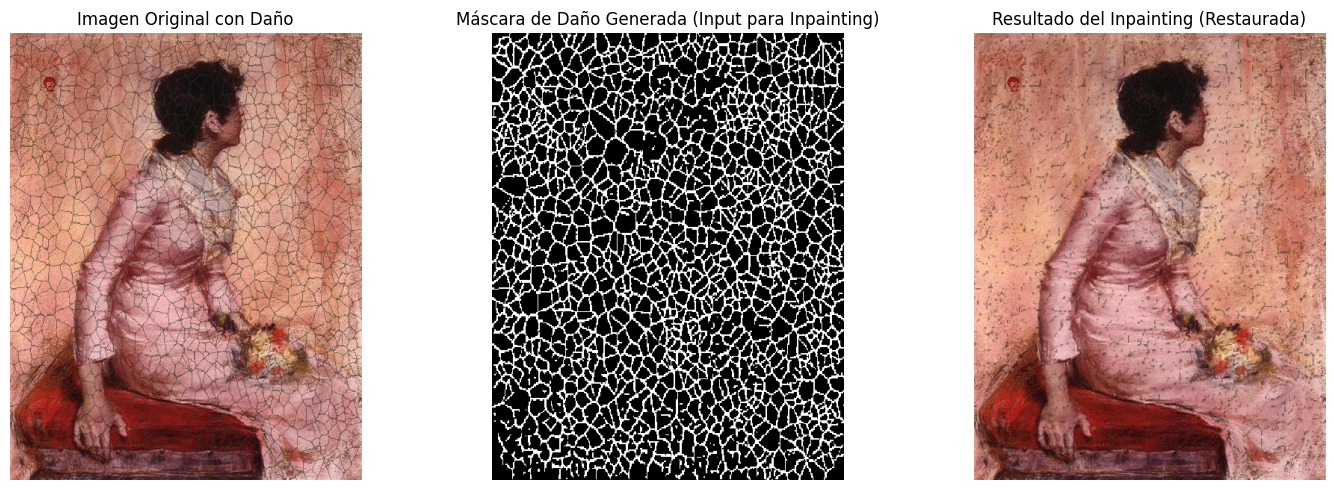

In [64]:
# --- PARTE 4: Visualización de Resultados ---

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(image_original_size)
ax[0].set_title('Imagen Original con Daño')

# Mostrar la máscara binarizada (reescalada al tamaño original)
ax[1].imshow(mask_boolean, cmap='gray')
ax[1].set_title('Máscara de Daño Generada (Input para Inpainting)')

ax[2].imshow(image_restored)
ax[2].set_title('Resultado del Inpainting (Restaurada)')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [65]:
# --- PARTE 1: Configuración y Carga ---
# Define la ruta de la imagen que quieres restaurar (debe ser una imagen con daño)
PATH_TO_TEST_IMAGE = 'drive/MyDrive/restaurAr-T/data/cracked-portrait.jpg'

# Carga el tensor de entrada para el modelo y la imagen original (sin normalizar)
input_tensor, image_original_size = preprocess_image(PATH_TO_TEST_IMAGE)

In [66]:
# --- PARTE 2: Segmentación Semántica (Generación de Máscara) ---

# Asegúrate de que tu modelo ya está cargado, por ejemplo:
# model = tf.keras.models.load_model('best_model.h5', compile=False)

# 1. Predecir la máscara de daño
# La predicción devuelve probabilidades (Ej: (1, 256, 256, 1))
predicted_mask_probs = model.predict(input_tensor)[0]

# 2. Binarizar la máscara de probabilidad (convertir a 0 o 1)
# Se usa un umbral de 0.5, ajusta si es necesario
mask_binary = (predicted_mask_probs > 0.5).astype(np.uint8)

# 3. Eliminar la dimensión de canal (squeeze) para obtener (Alto, Ancho)
mask_binary_squeezed = np.squeeze(mask_binary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [67]:
# --- PARTE 3: Inpainting (Relleno) ---

# Las dimensiones de la máscara (H, W) deben coincidir con la imagen original (H, W, C).
H_orig, W_orig, _ = image_original_size.shape

# 1. Reescalar la máscara binaria a las dimensiones de la imagen original
# Esto es CRUCIAL, ya que el modelo trabaja en 256x256, pero el inpainting se aplica al tamaño original.
mask_resized = cv2.resize(mask_binary_squeezed, (W_orig, H_orig),
                          interpolation=cv2.INTER_NEAREST)

# 2. Convertir la máscara a formato booleano (True/False)
# 'True' indica las áreas a rellenar (el daño)
mask_boolean = mask_resized.astype(bool)

# 3. Aplicar la función de inpainting de scikit-image
# La función requiere una imagen, la máscara booleana y multichannel=True para RGB.
image_restored = inpaint.inpaint_biharmonic(
    image_original_size, # Imagen original (sin normalizar)
    mask_boolean,         # Máscara booleana
    channel_axis=2       # Indica que la imagen tiene canales en el último eje (RGB)
)

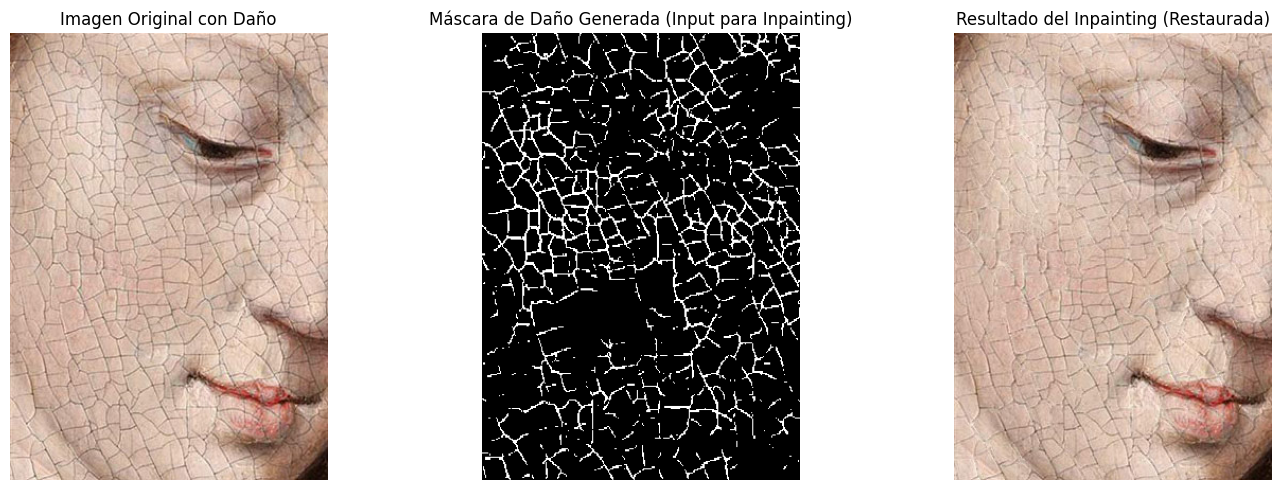

In [68]:
# --- PARTE 4: Visualización de Resultados ---

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(image_original_size)
ax[0].set_title('Imagen Original con Daño')

# Mostrar la máscara binarizada (reescalada al tamaño original)
ax[1].imshow(mask_boolean, cmap='gray')
ax[1].set_title('Máscara de Daño Generada (Input para Inpainting)')

ax[2].imshow(image_restored)
ax[2].set_title('Resultado del Inpainting (Restaurada)')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()